In [11]:
import cv2
import numpy as np
from skimage.segmentation import slic, mark_boundaries
import matplotlib.pyplot as plt

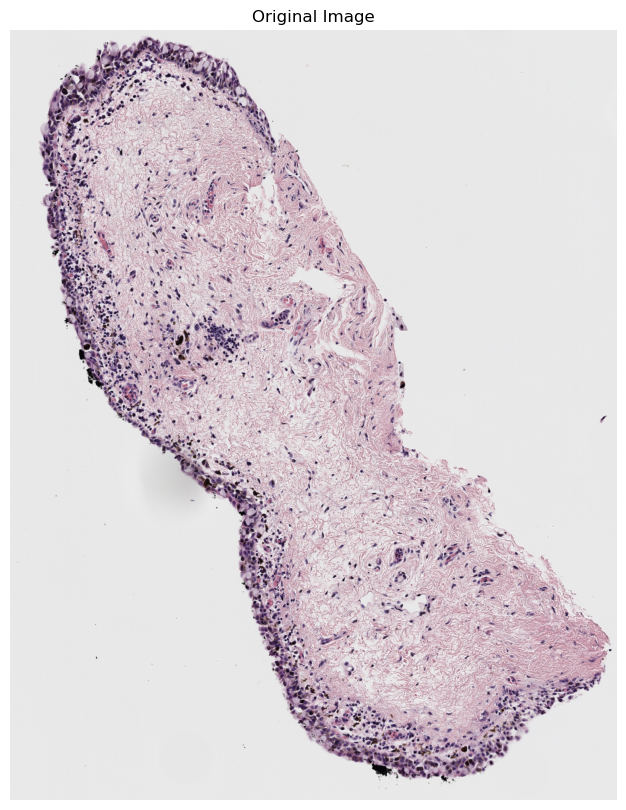

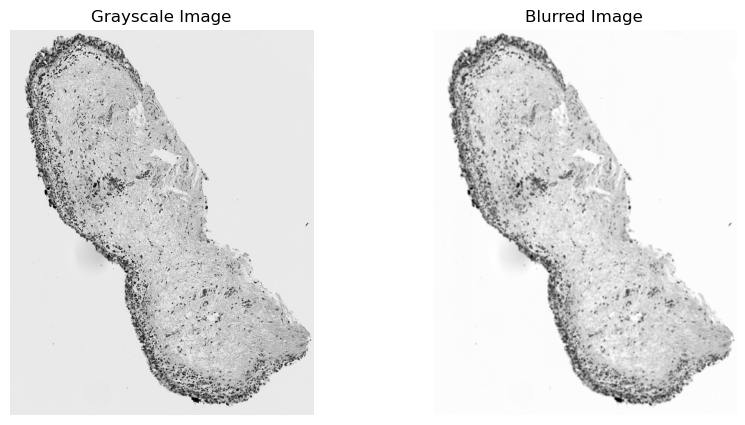

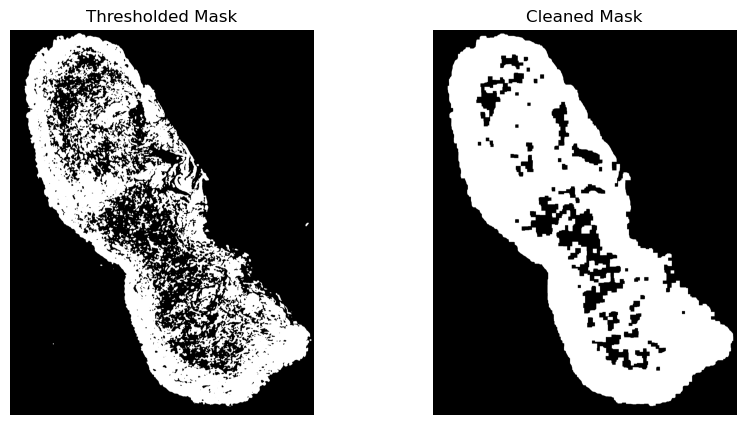

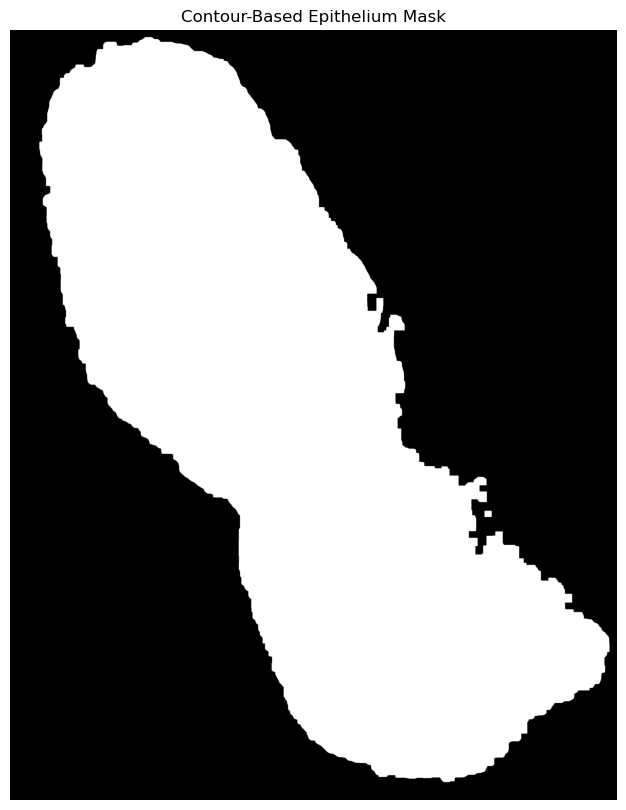

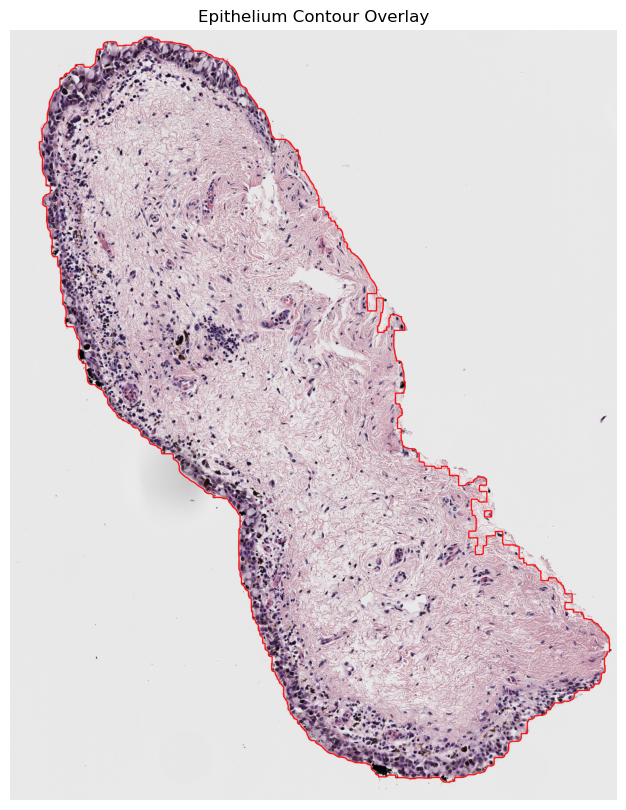

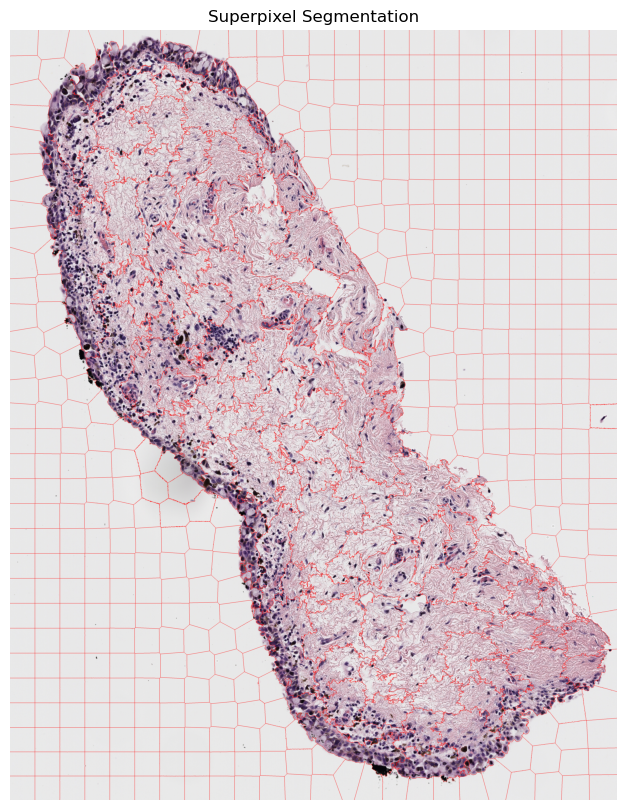

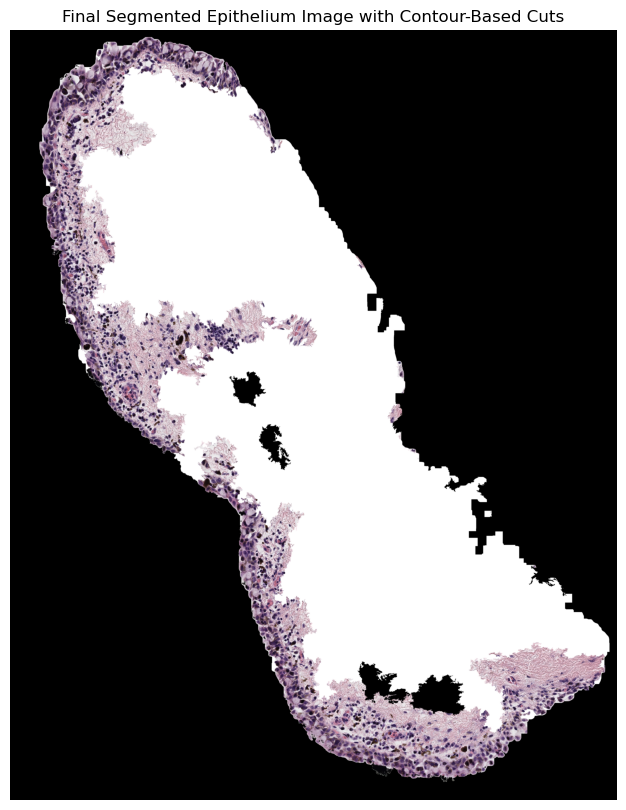

In [10]:
# Team 2's Code
def generate_epithelium_mask(image_path):
    image = cv2.imread(image_path)
    
    # Original image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (45, 45), 0)
    
    # Grayscale and blurred images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1), plt.imshow(gray_image, cmap='gray'), plt.title('Grayscale Image')
    plt.axis('off')
    plt.subplot(1, 2, 2), plt.imshow(blurred_image, cmap='gray'), plt.title('Blurred Image')
    plt.axis('off')
    plt.show()
    
    _, thresholded_mask = cv2.threshold(blurred_image, 200, 255, cv2.THRESH_BINARY_INV)
    kernel_huge = np.ones((45, 45), np.uint8)
    cleaned_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_CLOSE, kernel_huge)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel_huge)

    # Thresholded and cleaned mask images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1), plt.imshow(thresholded_mask, cmap='gray'), plt.title('Thresholded Mask')
    plt.axis('off')
    plt.subplot(1, 2, 2), plt.imshow(cleaned_mask, cmap='gray'), plt.title('Cleaned Mask')
    plt.axis('off')
    plt.show()
    
    kernel_medium = np.ones((25, 25), np.uint8)
    generalized_cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_medium)
    generalized_cleaned_mask = cv2.morphologyEx(generalized_cleaned_mask, cv2.MORPH_OPEN, kernel_medium)

    # Find contours for the generalized mask
    contours, _ = cv2.findContours(generalized_cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a separate mask
    contour_mask = np.zeros_like(generalized_cleaned_mask)
    cv2.drawContours(contour_mask, contours, -1, 255, thickness=cv2.FILLED)
    
    # Draw a red outline
    contoured_image = image.copy()
    cv2.drawContours(contoured_image, contours, -1, (0, 0, 255), 8)  # Draw red contours
    
    # Display contour mask
    plt.figure(figsize=(10, 10))
    plt.imshow(contour_mask, cmap='gray')
    plt.title("Contour-Based Epithelium Mask")
    plt.axis('off')
    plt.show()
    
    # Display the final contour overlay on the original image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(contoured_image, cv2.COLOR_BGR2RGB))
    plt.title("Epithelium Contour Overlay")
    plt.axis('off')
    plt.show()
    
    return contour_mask, contours, image





# My code from last week
# Modification: Cut Along Contour Boundaries
def create_and_cut_superpixels(image, contour_mask, contours, num_segments=750):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Generate and display superpixels
    segments = slic(image_rgb, n_segments=num_segments, compactness=10, start_label=1)
    plt.figure(figsize=(10, 10))
    plt.imshow(mark_boundaries(image_rgb, segments, color=(1, 0, 0)))
    plt.title("Superpixel Segmentation")
    plt.axis('off')
    plt.show()
    
    segmented_image = np.zeros_like(image_rgb)
    lower_purple = np.array([125, 40, 40])
    upper_purple = np.array([155, 255, 255])

    for segment_value in np.unique(segments):
        segment_mask = (segments == segment_value)
        
        # Separate parts inside and outside the contour using the contour mask
        inside_mask = np.logical_and(segment_mask, contour_mask > 0)
        outside_mask = np.logical_and(segment_mask, contour_mask == 0)

        # Process inside region
        if np.sum(inside_mask) > 0:
            inside_segment = np.zeros_like(image_rgb)
            inside_segment[inside_mask] = image_rgb[inside_mask]
            inside_hsv = cv2.cvtColor(inside_segment, cv2.COLOR_RGB2HSV)
            purple_inside_mask = cv2.inRange(inside_hsv, lower_purple, upper_purple)
            
            # Calculate purple concentration inside
            total_pixels_inside = np.sum(inside_segment[:, :, 0] > 0)
            purple_pixels_inside = np.sum(purple_inside_mask > 0)
            purple_concentration_inside = purple_pixels_inside / total_pixels_inside if total_pixels_inside > 0 else 0

            # Assign colors based on purple concentration for inside
            if purple_concentration_inside > 0.15:
                segmented_image[inside_mask] = image_rgb[inside_mask]
            elif purple_concentration_inside > 0.015:
                segmented_image[inside_mask] = [255, 255, 255]
            else:
                segmented_image[inside_mask] = [0, 0, 0]

        # Process outside region (background)
        if np.sum(outside_mask) > 0:
            segmented_image[outside_mask] = [0, 0, 0]  # Assign black to outside background

    # Display the final segmented image with contour overlay
    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image)
    plt.title("Final Segmented Epithelium Image with Contour-Based Cuts")
    plt.axis('off')
    plt.show()
    
    return segmented_image





# Combining Team 6's code with Team 2's code
def combined_contour_superpixel_segmentation(image_path):
    contour_mask, contours, original_image = generate_epithelium_mask(image_path)
    segmented_image = create_and_cut_superpixels(original_image, contour_mask, contours)


combined_contour_superpixel_segmentation('HighQualitySample.tif')